# depth map - image

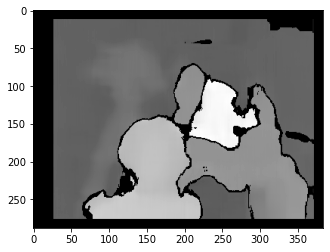

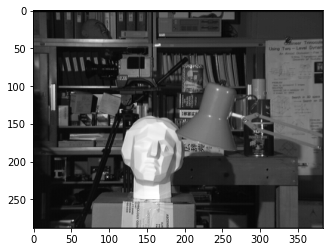

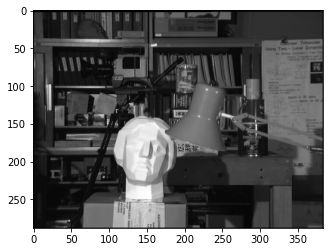

In [15]:
# https://leechamin.tistory.com/362
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 

imgL = cv2.imread("./image/tsukuba_l.png",0) 

h, w = imgL.shape[:2] 

imgR = cv2.imread("./image/tsukuba_r.png",0) 
imgR = cv2.resize(imgR,(w,h)) 


stereo = cv2.StereoBM_create(numDisparities=16, blockSize=25) # 16, 15     
# blocksize를 키울수록 노이즈들이 없어지고 이미지의 윤곽이 단순해짐
# 가까울수록 더 잘 잡아주는것 같음
disparity = stereo.compute(imgL,imgR) 

plt.imshow(disparity,'gray') 
plt.show()

plt.imshow(imgL,'gray') 
plt.show()
plt.imshow(imgR,'gray') 
plt.show()

# 영상에서 사진 캡쳐

In [4]:
import cv2 
import numpy as np
import sys
import cv2
import os


cap = cv2.VideoCapture(1) 

cnt = 0
if cap.isOpened(): 
    
    while True: 
        ret, frame = cap.read() 
        
        if ret: 
            cv2.imshow("camera",frame) #프레임 이미지 표시 
            
            key = cv2.waitKey(1)

            if key == 27:
                break
                
            elif key == ord('c'):
                file_name = './test' + str(cnt) + '.jpg'
                cv2.imwrite(file_name, frame)
                cnt += 1
                print('capture complete')
        else: 
            print("can't open camera") 
            
else:
    print("i can't open camera")
    
cap.release() 
cv2.destroyAllWindows()


capture complete
capture complete


# Face detection

In [4]:
# http://localhost:8888/notebooks/Documents/computer_vision_basic/computer_vision/opencv_DNN/DL_opencv_review.ipynb
import numpy as np
import sys
import cv2
import os


# model = './opencv_face_detector/opencv_face_detector_uint8.pb'
# config2 = './opencv_face_detector/opencv_face_detector.pbtxt'

model = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector_uint8.pb'
config = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector.pbtxt'

cap = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)



if not cap.isOpened():
    print('video open failed')
    sys.exit()

net = cv2.dnn.readNet(model, config)

# 이상하게 이 부분을 주석하면 정상 작동됨
# if not net.empty():
#     print('net load failed')
#     sys.exit()    
    
while 1:
    ret, frame = cap.read()
    
    if not ret:
        print('frame read failed')
        break
        
    blob = cv2.dnn.blobFromImage(frame, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward() ## out(1, 1, 200, 7)
    
    detect = out[0, 0, :, :]
    h, w = frame.shape[:2]
    
    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        
        if confidence > 0.5:  # face threshold
            x1 = int(detect[i, 3] * w)
            y1 = int(detect[i, 4] * h)
            x2 = int(detect[i, 5] * w)
            y2 = int(detect[i, 6] * h)
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            text = f'Face : {confidence : 4.2f}'
            cv2.putText(frame, text, (x1, y1 - 3), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
            
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(20) == 27:
        break
        
cap.release()
cv2.destroyAllWindows()

# Connect two Cameras

In [30]:
# https://www.youtube.com/watch?v=jGYNFssXiAQ
import numpy as np
import sys
import cv2
import os


caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)



while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    if (retl):
        cv2.imshow('l', imgl)
    
    if (retr):
        cv2.imshow('r', imgr)
    
    key = cv2.waitKey(30) & 0xff
    
    if key == 27:
        break
        
caml.release()
camr.release()
cv2.destroyAllWindows()

# epipolar

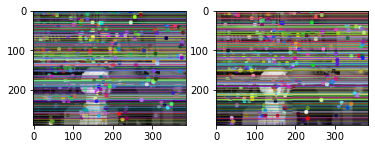

In [3]:
# http://www.gisdeveloper.co.kr/?p=6922
import cv2
import numpy as np
import matplotlib.pyplot as plt


img1 = cv2.imread("./image/tsukuba_l.png",0) 

h, w = img1.shape[:2] 

img2 = cv2.imread("./image/tsukuba_r.png",0) 
img2 = cv2.resize(img2,(w,h)) 



sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()


# Step 2-1. 1개의 웹캠에서 얼굴 인식 및 2개의 영상 송출

In [9]:
# http://localhost:8888/notebooks/Documents/computer_vision_basic/computer_vision/opencv_DNN/DL_opencv_review.ipynb
import numpy as np
import sys
import cv2
import os


model = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector_uint8.pb'
config = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector.pbtxt'

caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)

if not caml.isOpened():
    print('left video open failed')
    sys.exit()
    
if not camr.isOpened():
    print('right video open failed')
    sys.exit()

net = cv2.dnn.readNet(model, config)
  
    
while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    if not retl:
        print('imgl read failed')
        break
        
    blob = cv2.dnn.blobFromImage(imgl, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward() ## out(1, 1, 200, 7)
    
    detect = out[0, 0, :, :]
    h, w = imgl.shape[:2]
    
    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        
        if confidence > 0.5:  # face threshold
            x1 = int(detect[i, 3] * w)
            y1 = int(detect[i, 4] * h)
            x2 = int(detect[i, 5] * w)
            y2 = int(detect[i, 6] * h)
            
            cv2.rectangle(imgl, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            text = f'Face : {confidence : 4.2f}'
            cv2.putText(imgl, text, (x1, y1 - 3), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
    
    if (retl):
        cv2.imshow('l', imgl)        

    if (retr):
        cv2.imshow('r', imgr)
        
    if cv2.waitKey(20) == 27:
        break
        
caml.release()
cv2.destroyAllWindows()

# Step 2-2. 2개 웹캠으로 depth map 동작

In [20]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import time

caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)


# 16 15
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)  # 16 15
# numDisparities 은 2의 n승(최소 16)
# blockSize는 홀수이며 numDisparities 보다 작게

while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    
    if (retl):
#         imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY)
        cv2.imshow('l', imgl)
    
    if (retr):
#         imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)
        cv2.imshow('r', imgr)
        
    imgl = cv2.GaussianBlur(imgl, (0, 0), 3)
    imgr = cv2.GaussianBlur(imgr, (0, 0), 3)
    
    
    disparity = stereo.compute(cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)) 
    
    disparity = disparity.astype(np.uint8)
    
    cv2.imshow('depth', disparity)
    
    key = cv2.waitKey(30) & 0xff
    
    if key == 27:
        break
        
caml.release()
camr.release()
cv2.destroyAllWindows()


# Step 2-3. 2개의 웹캠을 활용하여 epiline 생성

In [7]:
# http://www.gisdeveloper.co.kr/?p=6922
import cv2
import numpy as np
import matplotlib.pyplot as plt


def drawlines(imgl,imgr,lines,pts1,pts2):
    ''' imgl - image on which we draw the epilines for the points in imgr
        lines - corresponding epilines '''
    
    r,c = imgl.shape
    imgl = cv2.cvtColor(imgl,cv2.COLOR_GRAY2BGR)
    imgr = cv2.cvtColor(imgr,cv2.COLOR_GRAY2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        imgl = cv2.line(imgl, (x0,y0), (x1,y1), color,1)
        imgl = cv2.circle(imgl,tuple(pt1),5,color,-1)
        imgr = cv2.circle(imgr,tuple(pt2),5,color,-1)
        
    return imgl,imgr


caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 400)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)


while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY)
    imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)
        
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(imgl,None)
    kp2, des2 = sift.detectAndCompute(imgr,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    #checks가 클수록 확인하는 feature 반복횟수가 증가하여 정확해지나, 느려짐
    search_params = dict(checks=100) 
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    good = []
    pts1 = []
    pts2 = []

    # 유사성 계수
    threshold = 0.9
    
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < threshold * n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
    
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)

    img5,img6 = drawlines(imgl, imgr, lines1, pts1, pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)

    img3,img4 = drawlines(imgr,imgl,lines2,pts2,pts1)

    # plt.subplot(121),plt.imshow(img5)
    # plt.subplot(122),plt.imshow(img3)
    # plt.show()

    if (retl):
        cv2.imshow('l', img5) # 5
    
    if (retr):
        cv2.imshow('r', img3) # 3
        
    key = cv2.waitKey(30) & 0xff
    
    if key == 27:
        break
        
caml.release()
camr.release()
cv2.destroyAllWindows()


# 실험

In [6]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import time

caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 1200)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 600)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 1200)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 600)


# 16 15
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=17)  # 16 15
# numDisparities 은 2의 n승(최소 16)
# blockSize는 홀수이며 numDisparities 보다 작게

while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    
    if (retl):
#         imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY)
        cv2.imshow('l', imgl)
    
    if (retr):
#         imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)
        cv2.imshow('r', imgr)
        
    imgl = cv2.GaussianBlur(imgl, (0, 0), 4)
    imgr = cv2.GaussianBlur(imgr, (0, 0), 4)
    
#     time.sleep(0.01) # second
    disparity = stereo.compute(cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)) 
#     time.sleep(0.01) # second
    disparity = disparity.astype(np.uint8)
    
    cv2.imshow('depth', disparity)
    
    key = cv2.waitKey(30) & 0xff
    
    if key == 27:
        break
        
caml.release()
camr.release()
cv2.destroyAllWindows()


# Capture & depth

In [2]:
import cv2 
import numpy as np
import sys
import cv2
import os


cap = cv2.VideoCapture(1) 

cnt = 0
if cap.isOpened(): 
    
    while True: 
        ret, frame = cap.read() 
        
        if ret: 
            cv2.imshow("camera",frame) #프레임 이미지 표시 
            
            key = cv2.waitKey(1)

            if key == 27:
                break
                
            elif key == ord('c'):
                file_name = './left.jpg'
                cv2.imwrite(file_name, frame)
                print('capture complete')
        else: 
            print("can't open camera") 
            
else:
    print("i can't open camera")
    
cap.release() 
cv2.destroyAllWindows()


In [13]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import time

caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)


# 16 15
# stereo = cv2.StereoBM_create(numDisparities=128, blockSize=17)  # 16 15
# stereo = cv2.StereoSGBM_create()
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=11)
# stereo = cv2.StereoS

# numDisparities 은 2의 n승(최소 16)
# blockSize는 홀수이며 numDisparities 보다 작게

while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    
    if (retl):
#         imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY)
        cv2.imshow('l', imgl)
        file_name_l = './left.jpg'
        cv2.imwrite(file_name_l, imgl)
        imgL = cv2.imread(file_name_l,1)

    if (retr):
#         imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)
        cv2.imshow('r', imgr)
        file_name_r = './right.jpg'
        cv2.imwrite(file_name_r, imgr)
        imgR = cv2.imread(file_name_r,1) 
        
    h, w = imgL.shape[:2] 
    imgR = cv2.resize(imgR,(w,h))
    
    imgR = cv2.add(imgR,  -50)
    imgL = cv2.add(imgL, -50)
    
#     imgL = cv2.GaussianBlur(imgL, (0, 0), 1)
#     imgR = cv2.GaussianBlur(imgR, (0, 0), 1)
    
    imgL = cv2.normalize(imgL, None, 0, 255, cv2.NORM_MINMAX, -1)
    imgR = cv2.normalize(imgR, None, 0, 255, cv2.NORM_MINMAX, -1)
    
    # -------------------------EQUALIZE---------------------------------
#     imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
#     imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
#     imgL = cv2.equalizeHist(imgL)
#     imgR = cv2.equalizeHist(imgR)
    # -------------------------MEDIAN---------------------------------
    
#     imgL = cv2.medianBlur(imgL, 1)
#     imgR = cv2.medianBlur(imgR, 1)
    
    # # --------------------------------------------------------------
    disparity = stereo.compute(cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)) 
#     disparity = stereo.compute(imgL, imgR) 
    disparity = disparity.astype(np.uint8)
    
    cv2.imshow('depth', disparity)
    
    key = cv2.waitKey(30) & 0xff
    
    if key == 27:
        break
        
caml.release()
camr.release()
cv2.destroyAllWindows()


# Dataset 만들기

In [2]:
# http://localhost:8888/notebooks/Documents/computer_vision_basic/computer_vision/opencv_DNN/DL_opencv_review.ipynb
import numpy as np
import sys
import cv2
import os
import pandas as pd

# label
# 0은 정상
# 1은 몸에 비해 얼굴이 가까울 때
# 2는 몸에 비해 얼굴이 멀 때

label = 2
data_len = 1000

model = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector_uint8.pb'
config = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector.pbtxt'

caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)

if not caml.isOpened():
    print('left video open failed')
    sys.exit()
    
if not camr.isOpened():
    print('right video open failed')
    sys.exit()

net = cv2.dnn.readNet(model, config)
  

feature = ['face_size_x', 'face_size_y', 'face_avg', 'body_avg', 'label']
df_dataset = pd.DataFrame(columns=feature)

cnt = 0

stereo = cv2.StereoBM_create(numDisparities=128, blockSize=11)

cv2.namedWindow('slice_l', cv2.WINDOW_AUTOSIZE)
cv2.namedWindow('slice_body', cv2.WINDOW_AUTOSIZE)

x1, x2 = 0, 100
y1, y2 = 0, 100

while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    if not retl:
        print('imgl read failed')
        break
        
    blob = cv2.dnn.blobFromImage(imgl, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward() ## out(1, 1, 200, 7)
    
    detect = out[0, 0, :, :]
    h, w = imgl.shape[:2]
    
    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        
        if confidence > 0.5:  # face threshold
            x1 = int(detect[i, 3] * w)
            y1 = int(detect[i, 4] * h)
            x2 = int(detect[i, 5] * w)
            y2 = int(detect[i, 6] * h)
            
            imgl_copy = imgl.copy()
            
            
            cv2.rectangle(imgl, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.rectangle(imgl, (int(x1 * 0.5), 400), (int(x2 * 1.3), y2), (0, 255, 0), 2)
            
            text = f'Face : {confidence : 4.2f}'
            cv2.putText(imgl, text, (x1, y1 - 3), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
    
            cv2.imshow('slice_l', imgl_copy[y1:y2, x1:x2])
            cv2.imshow('slice_body', imgl_copy[y2:400, int(x1 * 0.5):int(x2 * 1.3)])

        
            if cnt == data_len:
                print('count is done')
                file_name = 'label_' + str(label) + '.csv'
                df_dataset.to_csv(file_name)
                
                caml.release()
                camr.release()
                cv2.destroyAllWindows()
                sys.exit()

            else:
                cnt += 1

            if (retl):
                cv2.imshow('l', imgl) 
                file_name_l = './left.jpg'
                cv2.imwrite(file_name_l, imgl)
                imgL = cv2.imread(file_name_l,1)

            if (retr):
                cv2.imshow('r', imgr)
                file_name_r = './right.jpg'
                cv2.imwrite(file_name_r, imgr)
                imgR = cv2.imread(file_name_r,1)

            h, w = imgL.shape[:2] 
            imgR = cv2.resize(imgR,(w,h))

            imgR = cv2.add(imgR, -50)
            imgL = cv2.add(imgL, -50)

            imgL = cv2.normalize(imgL, None, 0, 255, cv2.NORM_MINMAX, -1)
            imgR = cv2.normalize(imgR, None, 0, 255, cv2.NORM_MINMAX, -1)

            disparity = stereo.compute(cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)) 
            disparity = disparity.astype(np.uint8)


            cv2.imshow('depth', disparity)

            depth_copy = disparity.copy()

            face_array = depth_copy[y1:y2, x1:x2]
            body_array = depth_copy[y2:400, int(x1 * 0.5):int(x2 * 1.3)]
            
            cv2.imshow('slice_d', face_array)
            cv2.imshow('depth_body', body_array)


            face_size_x = abs(x1 - x2)
            face_size_y = abs(y1 - y2)

            df_dataset.loc[cnt, 'face_size_x'] = face_size_x
            df_dataset.loc[cnt, 'face_size_y'] = face_size_y
            df_dataset.loc[cnt, 'face_avg'] = np.mean(face_array)
            df_dataset.loc[cnt, 'body_avg'] = np.mean(body_array)
            df_dataset.loc[cnt, 'label'] = label

    if cv2.waitKey(1) == 27:
        break
        
    print(cnt)
    
caml.release()
camr.release()
cv2.destroyAllWindows()

print(df_dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

SystemExit: 

# Result

In [4]:
# http://localhost:8888/notebooks/Documents/computer_vision_basic/computer_vision/opencv_DNN/DL_opencv_review.ipynb
import numpy as np
import sys
import cv2
import os
import pandas as pd
import pickle
import joblib
import time

load_model = joblib.load('./lr_0.pkl')

# label
# 0은 정상
# 1은 몸에 비해 얼굴이 가까울 때
# 2는 몸에 비해 얼굴이 멀 때


model = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector_uint8.pb'
config = '../computer_vision_basic/computer_vision/opencv_DNN/opencv_face_detector/opencv_face_detector.pbtxt'

caml = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
caml.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
caml.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)

camr = cv2.VideoCapture(1 + cv2.CAP_DSHOW)
camr.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
camr.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)

if not caml.isOpened():
    print('left video open failed')
    sys.exit()
    
if not camr.isOpened():
    print('right video open failed')
    sys.exit()

net = cv2.dnn.readNet(model, config)

stereo = cv2.StereoBM_create(numDisparities=128, blockSize=11)

# cv2.namedWindow('slice_l', cv2.WINDOW_AUTOSIZE)
# cv2.namedWindow('slice_body', cv2.WINDOW_AUTOSIZE)

x1, x2 = 0, 100
y1, y2 = 0, 100

test_y = 0

while 1:
    retl, imgl = caml.read()
    retr, imgr = camr.read()
    
    if not retl:
        print('imgl read failed')
        break
        
    blob = cv2.dnn.blobFromImage(imgl, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward() ## out(1, 1, 200, 7)
    
    detect = out[0, 0, :, :]
    h, w = imgl.shape[:2]
    
    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        
        if confidence > 0.8:  # face threshold
            x1 = int(detect[i, 3] * w)
            y1 = int(detect[i, 4] * h)
            x2 = int(detect[i, 5] * w)
            y2 = int(detect[i, 6] * h)
            
            imgl_copy = imgl.copy()
            
            
            cv2.rectangle(imgl, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.rectangle(imgl, (int(x1 * 0.5), 400), (int(x2 * 1.3), y2), (0, 255, 0), 2)
            
            text = f'Face : {confidence : 4.2f}'
            cv2.putText(imgl, text, (x1, y1 - 3), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
    
#             cv2.imshow('slice_l', imgl_copy[y1:y2, x1:x2])
#             cv2.imshow('slice_body', imgl_copy[y2:400, int(x1 * 0.5):int(x2 * 1.3)])


            if (retl):
                cv2.imshow('l', imgl) 
                file_name_l = './left.jpg'
                cv2.imwrite(file_name_l, imgl)
                imgL = cv2.imread(file_name_l,1)

            if (retr):
#                 cv2.imshow('r', imgr)
                file_name_r = './right.jpg'
                cv2.imwrite(file_name_r, imgr)
                imgR = cv2.imread(file_name_r,1)

            h, w = imgL.shape[:2] 
            imgR = cv2.resize(imgR,(w,h))

            imgR = cv2.add(imgR, -50)
            imgL = cv2.add(imgL, -50)

            imgL = cv2.normalize(imgL, None, 0, 255, cv2.NORM_MINMAX, -1)
            imgR = cv2.normalize(imgR, None, 0, 255, cv2.NORM_MINMAX, -1)

            disparity = stereo.compute(cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)) 
            disparity = disparity.astype(np.uint8)


            cv2.imshow('depth', disparity)

            depth_copy = disparity.copy()

            face_array = depth_copy[y1:y2, x1:x2]
            body_array = depth_copy[y2:400, int(x1 * 0.5):int(x2 * 1.3)]
            
#             cv2.imshow('slice_d', face_array)
#             cv2.imshow('depth_body', body_array)


            face_size_x = abs(x1 - x2)
            face_size_y = abs(y1 - y2)


            data = {'face_size_x' : face_size_x,
                    'face_size_y' : face_size_y,
                    'face_avg'    : np.mean(face_array),
                    'body_avg'    : np.mean(body_array)
                    }
            
            test_x = pd.DataFrame(data, index=[0])
            test_y = load_model.predict(test_x)
            
#             text_result = f'State : {test_y[0] : 4.1f}'
            text_result = "State is " + str(int(test_y[0]))
            
#             print(test_y[0])

            cv2.putText(imgr, text_result, (20, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.imshow('r', imgr)
        
    if cv2.waitKey(1) == 27:
        break
    
caml.release()
camr.release()
cv2.destroyAllWindows()

C:\Users\HPE\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\HPE\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HPE\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [8]:
import pickle
import joblib

load_model = joblib.load('./lr_0.pkl')

# test = pd.DataFrame(columns=feature)

data = {'face_size_x' : face_size_x,
        'face_size_y' : face_size_y,
        'face_avg'    : np.mean(face_array),
        'body_avg'    : np.mean(body_array)
       }
test_x = pd.DataFrame(data, index=[0])


test_y = load_model.predict(test_x)

test_y[0]

C:\Users\HPE\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


0